In [ ]:
# !pip install vaderSentiment

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
plt.style.use('ggplot')

In [2]:
import nltk
from nltk.stem import PorterStemmer
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Sklearn models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.metrics import classification_report
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Topic Modelling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import ast

In [3]:
# import data
df = pd.read_csv(r'C:\Users\Patrick\Documents\concordia-bootcamps\Final Project\data\game_reviews_combined.csv', usecols=['review', 'voted_up', 'genre'])
validation_df = pd.read_csv('steamcharts_with_genre.csv', usecols=['review', 'voted_up', 'genre'])

In [11]:
df_big = pd.concat([df, validation_df])

In [13]:
df_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86070 entries, 0 to 52786
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   review    85862 non-null  object
 1   voted_up  86070 non-null  bool  
 2   genre     85050 non-null  object
dtypes: bool(1), object(2)
memory usage: 2.1+ MB


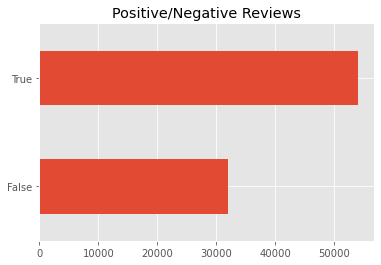

In [14]:
df_big['voted_up'].value_counts().sort_values().plot(kind='barh', title='Positive/Negative Reviews');

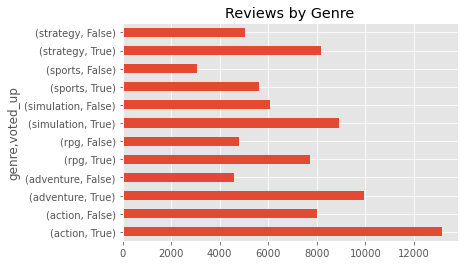

In [16]:
df_big.groupby('genre')['voted_up'].value_counts().plot(kind='barh')
plt.title('Reviews by Genre')
plt.show()

<AxesSubplot:title={'center':'Reviews by Genre'}, ylabel='genre'>

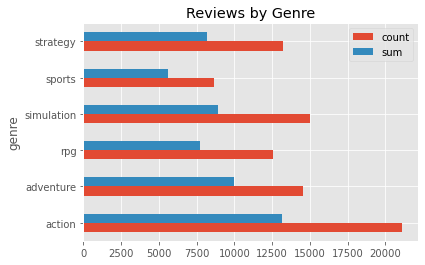

In [17]:
df_big.groupby('genre').agg(['count', 'sum'])['voted_up'].plot(kind='barh', title='Reviews by Genre')

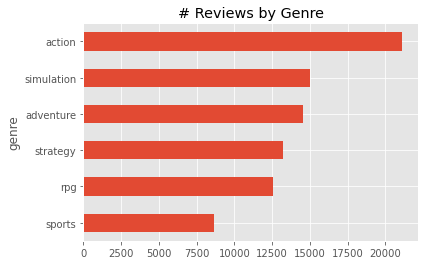

In [18]:
df_big.groupby('genre')['voted_up'].count().sort_values().plot(kind='barh', title='# Reviews by Genre');

In [19]:
# Cleaning Data - drops 1500 NAN rows
df_big.dropna(inplace=True)
df_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84845 entries, 0 to 52573
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   review    84845 non-null  object
 1   voted_up  84845 non-null  bool  
 2   genre     84845 non-null  object
dtypes: bool(1), object(2)
memory usage: 2.0+ MB


In [20]:
review_text = df_big['review']
review_text.head()

0    Immersive story, lovely characters and voice a...
1    This game is a slow burn, it builds over time....
2    The character interactions in the cutscenes in...
3                       Daryl Dixon Simulator.....YES!
4    This game is incredibly underrated. I find mys...
Name: review, dtype: object

In [21]:
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ", '☑': ' ', '☐':' ',
})

rep = dict((re.escape(k),v) for k, v in replaceDict.items())
pattern = re.compile('|'.join(rep.keys()))
def replacer(text):
    """
    Removes punctuation and symbols
    """
    return rep[re.escape(text.group(0))]

In [24]:
# Remove Stopwords
stopwords = nltk.corpus.stopwords.words("english")

def remove_stopwords(lst):
    """
    Removes stopwords from list of word tokens
    Returns a string
    """
    return ' '.join(word for word in lst if word not in stopwords)

def get_stems(lst):
    """
    Takes a list of words and stems them using PorterStemmer
    Returns a string with all words stemmed
    """
    ps = PorterStemmer()
    return ' '.join(ps.stem(w) for w in lst.split())

In [25]:
words = df_big['review'].str.replace(pattern, replacer).str.lower().str.split()
review_clean = words.apply(remove_stopwords)
review_stemmed = review_clean.apply(get_stems)
df_big['review_stemmed'] = review_stemmed

In [26]:
def FrequencyDistribution(series):
    """
    Takes in a string. Tokenizes and then reports the frequency distribution of those words
    Returns frequency distribution
    """
    fd_words = series.apply(nltk.word_tokenize)
    fd = fd_words.apply(nltk.FreqDist)
    return fd

fd = FrequencyDistribution(review_stemmed)
fd

0        {'immers': 1, 'stori': 3, 'love': 2, 'charact'...
1        {'game': 5, 'slow': 1, 'burn': 1, 'build': 1, ...
2        {'charact': 3, 'interact': 1, 'cutscen': 2, 'g...
3            {'daryl': 1, 'dixon': 1, 'simul': 1, 'ye': 1}
4        {'game': 5, 'incred': 1, 'underr': 1, 'find': ...
                               ...                        
52569    {'bother': 1, 'even': 2, 'sale': 1, 'go': 1, '...
52570    {'liter': 1, 'play': 1, 'game': 1, '2k': 1, 'a...
52571    {'play': 1, 'xcom': 1, 'style': 1, 'game': 5, ...
52572    {'miss': 1, '4': 1, 'shot': 1, '90': 1, 'chanc...
52573    {'like': 2, 'type': 1, 'game': 3, 'gener': 1, ...
Name: review, Length: 84845, dtype: object

In [27]:
# unigrams and bigrams, ignore words that appear in more than 75% of docs
tf = TfidfVectorizer(ngram_range=(1, 2), max_df=0.75)

X = df_big['review_stemmed']
y = df_big['voted_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

X_train = tf.fit_transform(X_train)         #fit_transform TfidfTransformer on training data
X_test = tf.transform(X_test)               #transform TfidfTransformer on testing data

In [28]:
def benchmark(clf, X_train=X_train, X_test=X_test):
    """
    Fit and predict using a classifier
    Returns the classifier description, the accuracy score, training time, and testing time
    """
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, train_time, test_time


In [29]:
# Ensemble Voting classifier
# Uses all 7 classifiers to predict a class. Majority vote wins.
rc = RidgeClassifier(tol=1e-2, solver="sparse_cg")
pc = Perceptron(max_iter=1000)
pac = PassiveAggressiveClassifier()
cnb = ComplementNB(alpha=0.01)
mnb = MultinomialNB(alpha=0.01)
bnb = BernoulliNB(alpha=0.01)
lsvc = LinearSVC(penalty='l2', dual=False, tol=1e-3)

eclf_sentiment = VotingClassifier(
     estimators=[('Ridge Classifier', rc), ('Perceptron', pc), ('Passive Aggressive Classifier', pac),
                 ('Complement Naive Bayes', cnb), ('Multinomial Naive Bayes', mnb), ('Bernoulli Naive Bayes', bnb),
                 ('LinearSVC', lsvc)
                ],
     voting='hard')

benchmark(eclf_sentiment)

________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('Ridge Classifier',
                              RidgeClassifier(solver='sparse_cg', tol=0.01)),
                             ('Perceptron', Perceptron()),
                             ('Passive Aggressive Classifier',
                              PassiveAggressiveClassifier()),
                             ('Complement Naive Bayes',
                              ComplementNB(alpha=0.01)),
                             ('Multinomial Naive Bayes',
                              MultinomialNB(alpha=0.01)),
                             ('Bernoulli Naive Bayes', BernoulliNB(alpha=0.01)),
                             ('LinearSVC', LinearSVC(dual=False, tol=0.001))])
train time: 21.725s
test time:  0.333s
accuracy:   0.892



('VotingClassifier',
 0.8920973539984678,
 21.725444078445435,
 0.3329508304595947)

              precision    recall  f1-score   support

       False       0.89      0.81      0.85      6279
        True       0.90      0.94      0.92     10690

    accuracy                           0.89     16969
   macro avg       0.89      0.88      0.88     16969
weighted avg       0.89      0.89      0.89     16969



C:\Users\Patrick\anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
C:\Users\Patrick\anaconda3\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


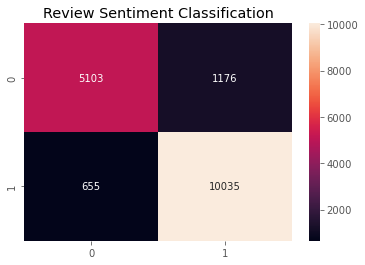

In [30]:
y_pred = eclf_sentiment.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Review Sentiment Classification');

In [31]:
# RandomSearch
params = {'Ridge Classifier__alpha':uniform(loc=1.0, scale=1000), 'Ridge Classifier__normalize':[True, False],
         'Perceptron__penalty':['l2','l1','elasticnet'],
         'Passive Aggressive Classifier__C':uniform(loc=1.0, scale=1000),
         'Complement Naive Bayes__alpha':uniform(loc=1.0, scale=1000), 'Complement Naive Bayes__norm':[True, False],
         }
eclf_sentiment_RS = RandomizedSearchCV(eclf_sentiment, params, random_state=101, n_iter=50)
search_sentiment = eclf_sentiment_RS.fit(X_train, y_train)
print(search_sentiment.best_estimator_)

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is 

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavio

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavio

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavio

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavio

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavio

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavio

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavio

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavio

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavio

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavio

C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


VotingClassifier(estimators=[('Ridge Classifier',
                              RidgeClassifier(alpha=2.330395678259211,
                                              normalize=False,
                                              solver='sparse_cg', tol=0.01)),
                             ('Perceptron', Perceptron(penalty='l1')),
                             ('Passive Aggressive Classifier',
                              PassiveAggressiveClassifier(C=953.6843579744861)),
                             ('Complement Naive Bayes',
                              ComplementNB(alpha=517.3986277024461)),
                             ('Multinomial Naive Bayes',
                              MultinomialNB(alpha=0.01)),
                             ('Bernoulli Naive Bayes', BernoulliNB(alpha=0.01)),
                             ('LinearSVC', LinearSVC(dual=False, tol=0.001))])


In [32]:
# After 2.5 hours, the RandomSearchCV improved the model by 0.02%
eclf_sentiment_best = search_sentiment.best_estimator_
eclf_sentiment_best.score(X_test, y_test)

0.892215215982085

In [52]:
# Using Vader Sentiment Analysis to improve the model
# I didn't end up using this in the final model as it didn't add any predictive power
def sentiment_scores(sentence):
    """
    Creates a sentiment score for text
    Returns 1 for positive, 0 for neutral, -1 for negative sentiment polarity reviews
    """
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    # polarity_scores method of SentimentIntensityAnalyzer
    # oject gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    # +/- 0.05 is the cutoff the authors suggest for neutrality
    if sentiment_dict['compound'] >= 0.05 :
        return 1
    elif sentiment_dict['compound'] <= - 0.05 :
        return -1
    else :
        return 0

In [70]:
predicted_sentiment = df_big['review'].apply(sentiment_scores)

In [72]:
df_big['predicted_sentiment'] = predicted_sentiment

In [104]:
# unigrams and bigrams, ignore words that appear in more than 75% of docs
tf = TfidfVectorizer(ngram_range=(1, 2), max_df=0.75)

X = df_big['review_stemmed']
y = df_big['voted_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

X_train = tf.fit_transform(X_train)         #fit_transform TfidfTransformer on training data
X_test = tf.transform(X_test)               #transform TfidfTransformer on testing data

# Ensemble Voting classifier
# Uses all 7 classifiers to predict a class. Majority vote wins.
rc = RidgeClassifier(tol=1e-2, solver="sparse_cg")
pc = Perceptron(max_iter=1000)
pac = PassiveAggressiveClassifier()
cnb = ComplementNB(alpha=0.01)
mnb = MultinomialNB(alpha=0.01)
bnb = BernoulliNB(alpha=0.01)
lsvc = LinearSVC(penalty='l2', dual=False, tol=1e-3)

eclf_sentiment = VotingClassifier(
     estimators=[('Ridge Classifier', rc), ('Perceptron', pc), ('Passive Aggressive Classifier', pac),
                 ('Complement Naive Bayes', cnb), ('Multinomial Naive Bayes', mnb), ('Bernoulli Naive Bayes', bnb),
                 ('LinearSVC', lsvc)
                ],
     voting='hard')

benchmark(eclf_sentiment)

________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('Ridge Classifier',
                              RidgeClassifier(solver='sparse_cg', tol=0.01)),
                             ('Perceptron', Perceptron()),
                             ('Passive Aggressive Classifier',
                              PassiveAggressiveClassifier()),
                             ('Complement Naive Bayes',
                              ComplementNB(alpha=0.01)),
                             ('Multinomial Naive Bayes',
                              MultinomialNB(alpha=0.01)),
                             ('Bernoulli Naive Bayes', BernoulliNB(alpha=0.01)),
                             ('LinearSVC', LinearSVC(dual=False, tol=0.001))])
train time: 12.697s
test time:  0.176s
accuracy:   0.892



('VotingClassifier',
 0.8921562849902764,
 12.696874380111694,
 0.1760399341583252)

In [164]:
# Some example test reviews
a = ["""Doomed to die.

MGH is a fairly well polished, well supported, flashy prop hunt game which I can imagine no future for apart from it being ultimately consumed by an increasingly competitive, ever dwindling community peppered with toxic dirtbags. For those of you who have played your fair share of online competitive multiplayer games, this is a pattern I am sure you are familiar with.

1. Notice the game in the "New and Trending" list
2. Decide to fork over $20 to try it out
3. Have a blast for 2-3 hours while you slowly start to understand the nuances of the mechanics
4. Eventually get matched into a game with people who have been playing the game nonstop since beta
5. Realize that apart from a few key abilities and weapons that are easily exploitable, most of the hunter upgrades you spent hours unlocking are pretty useless compared to the harpoon gun + ecto sensor
6. Realize that hiding as a ghost is less effective than simply finding the smallest object in a level and spending the whole game darting around, dodging the hunter's attacks until midnight

The game advertises itself as a fun "hide and seek" game. This is false. MGH game is basically Call of Duty dressed up to look like a fun prop hunt game to play casually.

Unfortunately, I don't see these as issues that can be fixed through anything short of a total overhaul of the mechanics. The developer's claim that the "win rates hover around 50 / 50" simply reinforces my opinion that any nerfs made to gameplay elements like hunter ammo, harpoon limitations, etc. will actually throw the game balance out of whack unless nerfs are made to the ghosts as well.

Overwatch had a similar issue when the pro scene discovered GOATS comp, which ultimately led to the enforcement of team comp in QP and Ranked play.

Bottom line: there's just no good solution to mechanics that are this fundamentally opposed to what the game is advertised as.

Before I wrap up, I do want to recognize that the developers seem to be very responsive, passionate, and invested in working with their community to make this game great. Sadly, I don't expect this to pan out in the long run, but I wish them the best!""",
    """Terrible game"""]
a = tf.transform(a)
eclf_sentiment.predict(a)

array([ True,  True])

In [197]:
# remove_stopwords(rev[0])
b = get_stems(remove_stopwords(rev[0].split()))
# b = list(b)
b
b = tf.transform([b])
eclf_sentiment.predict(b)

array([False])

### Saving Sentiment Classifier Model

In [202]:
# Saving the model
file_name = 'sentiment_classifier_best_final.pkl'

with open(file_name, 'wb') as file:
    pickle.dump(eclf_sentiment,file)
    
with open('tfidf_sentiment_best_final.pkl', 'wb') as output:
    pickle.dump(tf, output)

## Genre Classifier Model

In [133]:
# unigrams and bigrams, ignore words that appear in more than 75% of docs
tf = TfidfVectorizer(ngram_range=(1, 2), max_df=0.75)

X = df_big['review_stemmed']
y = df_big['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

X_train = tf.fit_transform(X_train)         #fit_transform TfidfTransformer on training data
X_test = tf.transform(X_test)               #transform TfidfTransformer on testing data

In [107]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.5934350875125228

In [34]:
# Testing out many classifiers to see what to include in the ensemble classifier

results = []
for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), 'Ridge Classifier'),
    (RidgeClassifier(tol=1e-2, solver="sparse_cg"), 'Ridge Classifier'),
    (Perceptron(max_iter=1000), 'Perceptron Classifier'),
    (PassiveAggressiveClassifier(), 'Passive Aggressive Classifier'),
):
    print(name)
    results.append(benchmark(clf))

for penalty in ['l1', 'l2']:
    print(f'{penalty}')
    results.append(LinearSVC(penalty=penalty, dual=False, class_weight='balanced'))
    results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty=penalty)))

results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet")))

for clf, name in (
    (MultinomialNB(), 'Multinomial Naive Bayes'),
    (BernoulliNB(), 'Bernoulli Naive Bayes'),
    (ComplementNB(), 'Complement Naive Bayes'),
):
    print(name)
    results.append(benchmark(clf))


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)


C:\Users\Patrick\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train time: 18.985s
test time:  0.045s
accuracy:   0.598

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sparse_cg', tol=0.01)
train time: 13.044s
test time:  0.075s
accuracy:   0.598

Perceptron Classifier
________________________________________________________________________________
Training: 
Perceptron()
train time: 2.351s
test time:  0.073s
accuracy:   0.563

Passive Aggressive Classifier
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier()
train time: 4.881s
test time:  0.070s
accuracy:   0.577

l1
________________________________________________________________________________
Training: 
SGDClassifier(max_iter=50, penalty='l1')
train time: 5.121s
test time:  0.075s
accuracy:   0.373

l2
________________________________________________________________________________
Training: 
SGDClassifier(max_iter=50)
train time: 2.517s
te

In [162]:
# Using an Ensemble voting classifier to get the best predictions from multiple models
rc = RidgeClassifier(tol=1e-2, solver="sparse_cg", class_weight='balanced')
pc = Perceptron(max_iter=1000, class_weight='balanced')
pac = PassiveAggressiveClassifier()
cnb = ComplementNB()
lr = LogisticRegression(solver='saga', multi_class='multinomial', class_weight='balanced')

eclf_genre = VotingClassifier(
     estimators=[('Ridge Classifier', rc), ('Perceptron', pc), ('Passive Aggressive Classifier', pac),
                 ('Complement Naive Bayes', cnb), ('Logistic Regression', lr)],
     voting='hard')

benchmark(eclf_genre)

________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('Ridge Classifier',
                              RidgeClassifier(class_weight='balanced',
                                              solver='sparse_cg', tol=0.01)),
                             ('Perceptron',
                              Perceptron(class_weight='balanced')),
                             ('Passive Aggressive Classifier',
                              PassiveAggressiveClassifier()),
                             ('Complement Naive Bayes', ComplementNB()),
                             ('Logistic Regression',
                              LogisticRegression(class_weight='balanced',
                                                 multi_class='multinomial',
                                                 solver='saga'))])
train time: 17.623s
test time:  0.209s
accuracy:   0.594



('VotingClassifier',
 0.5940243974306088,
 17.622549533843994,
 0.20922017097473145)

              precision    recall  f1-score   support

      action       0.51      0.73      0.60      4244
   adventure       0.59      0.53      0.56      2952
         rpg       0.67      0.55      0.60      2449
  simulation       0.58      0.54      0.56      2931
      sports       0.75      0.60      0.66      1668
    strategy       0.72      0.57      0.64      2725

    accuracy                           0.60     16969
   macro avg       0.64      0.59      0.60     16969
weighted avg       0.62      0.60      0.60     16969



C:\Users\Patrick\anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
C:\Users\Patrick\anaconda3\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


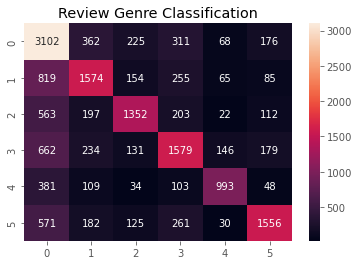

In [135]:
y_pred = eclf_genre.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Review Genre Classification');

### Saving the Genre Classifier Model

In [136]:
# Saving the model
file_name = 'genre_classifier_best.pkl'

with open(file_name, 'wb') as file:
    pickle.dump(eclf_genre,file)
with open('tfidf_genre_best.pkl', 'wb') as output:
    pickle.dump(tf, output)

In [153]:
rev = ["""Australian servers are dead, don't buy unless you want your soul to noclip through your body in yankland servers""",
      """Texture changing simulator. No real sense of accomplishment and a very weird visual/graphic style.""",
      """♥♥♥♥♥♥♥ horrific i cant even get past the first ♥♥♥♥♥♥♥ car because i cannot pick up or use the phone in the game period ♥♥♥♥♥♥♥ WOULD LIKE A REFUND OR A FIXTURE ASAP>>> FIX THE PHONE ISSUE OR SOMETHING OR THERE IS A REFUND HAPPENING!!!!<<<<""",
      """This game is fantastic, just needs to work on communication, graphics, map, characters, economy, how the units aim, realistic unit movement, anti aliasing, the ai, diplomacy, rational decision making by ai, the HUD, the tutorial, time to load, synchronization, the launcher, understandability and getting a new developer team."""]

rev_return = eclf_genre.predict(tf.transform(rev))

In [156]:
rev_return[0]

'action'

## Topic Modelling

In [108]:
id2word = corpora.Dictionary(fd)

corpus = []
for text in fd:
    new = id2word.doc2bow(text)
    corpus.append(new)

print (corpus[0][0:20])

word = id2word[[0][:1][0]]
print (word)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]
1


In [109]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=5,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [110]:
lda_model.show_topic(5)

[('account', 0.0434924),
 ('solo', 0.03515456),
 ('path', 0.034367513),
 ('polish', 0.024815334),
 ('biggest', 0.023588581),
 ('immedi', 0.018600047),
 ('setup', 0.017668996),
 ('imo', 0.015337193),
 ('pre', 0.015182037),
 ('de', 0.012638664)]

In [111]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\Patrick\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.197578 -0.437627       1        1  47.415338
6      0.090716 -0.451005       2        1  46.082133
7     -0.352068 -0.090421       3        1   2.058198
0     -0.269173  0.336989       4        1   1.723978
5      0.302823 -0.078436       5        1   0.936974
1      0.307148  0.168177       6        1   0.785617
8      0.100298  0.262718       7        1   0.428396
3     -0.039067  0.035290       8        1   0.320863
2     -0.010272  0.161678       9        1   0.222208
4      0.067172  0.092637      10        1   0.026294, topic_info=             Term          Freq         Total Category  logprob  loglift
57           game  57571.000000  57571.000000  Default  30.0000  30.0000
144          play  25627.000000  25627.000000  Default  29.0000  29.0000
60           good  17422.000000  17422.000000  Default  28.0000  28.0000
174           fun  17476.000000  17476.000000  Default  27.0000  27.0000
59            get  15939.000000  15939.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
9593           rs      0.011940      1.065575  Topic10 -10.7591   3.7522
3628          ini      0.011846      1.050189  Topic10 -10.7670   3.7588
18546       smite      0.012151      1.185370  Topic10 -10.7416   3.6631
5110   dishearten      0.011905      1.093047  Topic10 -10.7620   3.7238
29970      gaijin      0.011829      2.048303  Topic10 -10.7685   3.0893

[423 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1         1  0.969549    10
1         3  0.030216    10
6694      9  0.940191  1060
2         1  0.830312     2
2         2  0.129584     2
...     ...       ...   ...
130       3  0.995065     ‘
1351      3  0.091269     ’
1351      6  0.906174     ’
1352      6  0.990024     “
1353      6  0.989927     ”

[503 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 8, 1, 6, 2, 9, 4, 3, 5])

In [112]:
def lda_vis(fd):
    """
    Takes a frequency distribution
    Returns a visualization of LDA (Latent Dirichlet Allocation) topic model
    """
    def make_lda(fd):
        id2word = corpora.Dictionary(fd)
        corpus = [id2word.doc2bow(text) for text in fd]
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=25,
                                               random_state=100,
                                               update_every=5,
                                               chunksize=100,
                                               passes=20,
                                               alpha="auto")
        return model, corpus, id2word
    
    model, corpus, id2word = make_lda(fd)
    vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word, mds="mmds", R=25)
    return vis

In [120]:
positive_reviews = df_big[df_big['voted_up']==1]['review_stemmed']
negative_reviews = df_big[df_big['voted_up']==0]['review_stemmed']

pos_fd = FrequencyDistribution(positive_reviews)
neg_fd = FrequencyDistribution(negative_reviews)

In [157]:
positive_lda = lda_vis(pos_fd)
positive_lda

C:\Users\Patrick\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.147657  0.511844       1        1  46.150330
2     -0.508886  0.226886       2        1  24.125327
24    -0.339347  0.405456       3        1  14.967552
6      0.159099  0.451143       4        1   2.155133
0     -0.232856 -0.382480       5        1   1.294641
10     0.450959  0.088113       6        1   1.010560
7      0.038743  0.298161       7        1   0.919349
3      0.304285  0.251103       8        1   0.854175
13    -0.393182 -0.102192       9        1   0.838558
4      0.295410 -0.313346      10        1   0.761741
18    -0.003692 -0.394500      11        1   0.596137
20    -0.262529 -0.202796      12        1   0.580052
5      0.310707 -0.156594      13        1   0.561754
21    -0.003377  0.160343      14        1   0.538945
19     0.138609 -0.309684      15        1   0.501105
15    -0.239799  0.013712      16        1   0.493677
22     0.067549 -0.237450      17        1   0.467838
23     0.310315 -0.020703      18        1   0.463972
14     0.068902  0.051011      19        1   0.451712
8      0.175763 -0.103799      20        1   0.450335
9     -0.097344 -0.250115      21        1   0.432031
12    -0.135163  0.103358      22        1   0.421946
16     0.204356  0.085917      23        1   0.399418
11    -0.035745 -0.116338      24        1   0.345742
17    -0.125119 -0.057051      25        1   0.217971, topic_info=        Term          Freq         Total Category  logprob  loglift
57      game  41602.000000  41602.000000  Default  25.0000   25.000
256     best   5303.000000   5303.000000  Default  24.0000   24.000
144     play  16413.000000  16413.000000  Default  23.0000   23.000
174      fun  15550.000000  15550.000000  Default  22.0000   22.000
60      good  16229.000000  16229.000000  Default  21.0000   21.000
...      ...           ...           ...      ...      ...      ...
2828   choos      0.033596      1.511724  Topic25 -11.1737    2.322
2861   broke      0.033596      1.511723  Topic25 -11.1737    2.322
2879    ship      0.033596      1.511724  Topic25 -11.1737    2.322
2909   clean      0.033596      1.511723  Topic25 -11.1737    2.322
2939  specif      0.033596      1.511723  Topic25 -11.1737    2.322

[803 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
988      16  0.994860     0
1         4  0.040047    10
1         9  0.959548    10
1184     24  0.824252  1080
1150     14  0.950220   10x
...     ...       ...   ...
1266      4  0.077255     ’
1266     12  0.918478     ’
1267     12  0.978660     “
1268     12  0.985670     ”
2387     15  0.976045     👍

[825 rows x 3 columns], R=25, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 25, 7, 1, 11, 8, 4, 14, 5, 19, 21, 6, 22, 20, 16, 23, 24, 15, 9, 10, 13, 17, 12, 18])

In [158]:
negative_lda = lda_vis(neg_fd)
negative_lda

C:\Users\Patrick\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.223040  0.503232       1        1  70.217362
9     -0.533530  0.089889       2        1  13.017305
17    -0.416266  0.339372       3        1   9.512651
19     0.384612  0.176859       4        1   0.772432
18    -0.175929 -0.393091       5        1   0.763816
13     0.397560 -0.024293       6        1   0.568834
3      0.094461  0.344308       7        1   0.522706
0      0.243238  0.258174       8        1   0.459649
11    -0.316229 -0.109004       9        1   0.455742
5      0.251880 -0.299632      10        1   0.421383
10     0.015490 -0.350323      11        1   0.384432
14    -0.238615 -0.231741      12        1   0.351074
22     0.291916 -0.135010      13        1   0.300729
16    -0.043912  0.197423      14        1   0.287298
21     0.134998 -0.226607      15        1   0.281674
12    -0.181896  0.032869      16        1   0.260835
7      0.003189 -0.229677      17        1   0.242143
1      0.192469  0.042498      18        1   0.238469
8      0.088116  0.198760      19        1   0.198741
20     0.135592 -0.076651      20        1   0.153324
6     -0.037970 -0.123146      21        1   0.146863
24    -0.070942  0.082497      22        1   0.144668
2      0.065445  0.005546      23        1   0.120323
15    -0.069244 -0.050795      24        1   0.090608
23     0.008607 -0.021459      25        1   0.086940, topic_info=        Term          Freq         Total Category  logprob  loglift
90      game  23950.000000  23950.000000  Default  25.0000  25.0000
656     shit   1170.000000   1170.000000  Default  24.0000  24.0000
974     fuck   1093.000000   1093.000000  Default  23.0000  23.0000
69     enemi   1869.000000   1869.000000  Default  22.0000  22.0000
176     play  12210.000000  12210.000000  Default  21.0000  21.0000
...      ...           ...           ...      ...      ...      ...
1846      dl      2.835122      3.723159  Topic25  -5.7638   6.7752
2802  humili      2.694243      3.582279  Topic25  -5.8148   6.7628
1848  farcri      2.515214      3.403251  Topic25  -5.8835   6.7453
4364    crow      2.423989      3.312025  Topic25  -5.9205   6.7356
2807  marvel      4.934302     11.767684  Topic25  -5.2097   6.1786

[754 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
3240     14  0.988865     #
3573     20  0.900524    03
1861     24  0.884311  10hr
1862      7  0.982191   150
3918     13  0.979443  16gb
...     ...       ...   ...
1815     22  0.956057   это
1818     22  0.921439     я
844      21  0.994841     ’
1065     11  0.986037     “
1066     11  0.990471     ”

[796 rows x 3 columns], R=25, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 18, 20, 19, 14, 4, 1, 12, 6, 11, 15, 23, 17, 22, 13, 8, 2, 9, 21, 7, 25, 3, 16, 24])

In [159]:
pyLDAvis.save_html(positive_lda, 'positive_lda.html')
pyLDAvis.save_html(negative_lda, 'negative_lda.html')

In [199]:
full_fd = FrequencyDistribution(df_big['review_stemmed'])

In [200]:
full_lda = lda_vis(full_fd)
full_lda

C:\Users\Patrick\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.135429  0.537537       1        1  61.853067
21    -0.537317  0.103513       2        1  11.789318
14    -0.392878  0.384940       3        1  10.910450
19     0.459158  0.274367       4        1   4.464375
5     -0.217648 -0.408781       5        1   1.018259
4      0.166779  0.416457       6        1   1.016925
7      0.080476  0.306208       7        1   0.697325
12     0.283398  0.185727       8        1   0.640359
2     -0.364080 -0.123235       9        1   0.598171
11     0.330181 -0.274573      10        1   0.588287
0     -0.011291 -0.432318      11        1   0.578130
17    -0.288767 -0.255274      12        1   0.553349
15     0.382952 -0.115211      13        1   0.523651
20    -0.098523  0.263334      14        1   0.521626
22     0.184003 -0.375795      15        1   0.518786
23    -0.268451  0.111812      16        1   0.506688
6      0.087350 -0.281387      17        1   0.488145
10     0.346880  0.022553      18        1   0.452051
1      0.075760  0.115421      19        1   0.387689
3      0.207238 -0.128155      20        1   0.369067
8     -0.082430 -0.236539      21        1   0.341322
16    -0.084108  0.080356      22        1   0.318968
18     0.137794 -0.024759      23        1   0.313797
13    -0.051780 -0.091633      24        1   0.275788
24    -0.209265 -0.054564      25        1   0.274407, topic_info=          Term          Freq         Total Category  logprob  loglift
57        game  65417.000000  65417.000000  Default  25.0000  25.0000
144       play  29125.000000  29125.000000  Default  24.0000  24.0000
174        fun  19853.000000  19853.000000  Default  23.0000  23.0000
60        good  19789.000000  19789.000000  Default  22.0000  22.0000
229       like  20623.000000  20623.000000  Default  21.0000  21.0000
...        ...           ...           ...      ...      ...      ...
2891     forev      0.039669      1.361131  Topic25 -11.9037   2.3628
3086       mod      0.039669      1.361133  Topic25 -11.9037   2.3628
6808  launcher      0.039669      1.361132  Topic25 -11.9037   2.3628
2798   terribl      0.039669      1.361132  Topic25 -11.9037   2.3628
2809     delet      0.039669      1.361132  Topic25 -11.9037   2.3628

[767 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1         3  0.986652   10
1         6  0.013200   10
2695     19  0.872407  10€
1253     10  0.996958   11
2240     15  0.723890  126
...     ...       ...  ...
1351      7  0.947263    ’
1352      7  0.992260    “
1353      7  0.995335    ”
1115     15  0.844754    ✅
1116     15  0.639923    🔲

[751 rows x 3 columns], R=25, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 22, 15, 20, 6, 5, 8, 13, 3, 12, 1, 18, 16, 21, 23, 24, 7, 11, 2, 4, 9, 17, 19, 14, 25])

In [201]:
pyLDAvis.save_html(full_lda, 'full_lda.html')